In [1]:
import pickle
import pandas as pd
import seaborn as sea

import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneGroupOut

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor

from sklearn.neighbors import RadiusNeighborsRegressor, KNeighborsRegressor

#### Reading data

In [2]:
trainData = pd.read_csv('./Data/train.csv',index_col='ID_LAT_LON_YEAR_WEEK')

In [3]:
trainData.head()

,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
ID_LAT_LON_YEAR_WEEK,,,,,,,,,,,,,,,,,,,,,
ID_-0.510_29.290_2019_00,-0.51,29.29,2019,0,-0.000108,0.603019,-0.000065,0.255668,-98.593887,50.843559,...,3664.436218,61085.809570,2615.120483,15.568533,0.272292,-12.628986,35.632416,-138.786423,30.752140,3.750994
ID_-0.510_29.290_2019_01,-0.51,29.29,2019,1,0.000021,0.728214,0.000014,0.130988,16.592861,39.137194,...,3651.190311,66969.478735,3174.572424,8.690601,0.256830,30.359375,39.557633,-145.183930,27.251779,4.025176
ID_-0.510_29.290_2019_02,-0.51,29.29,2019,2,0.000514,0.748199,0.000385,0.110018,72.795837,52.868816,...,4216.986492,60068.894448,3516.282669,21.103410,0.251101,15.377883,30.401823,-142.519545,26.193296,4.231381
ID_-0.510_29.290_2019_03,-0.51,29.29,2019,3,NaN,NaN,NaN,NaN,NaN,NaN,...,5228.507736,51064.547339,4180.973322,15.386899,0.262043,-11.293399,24.380357,-132.665828,28.829155,4.305286
ID_-0.510_29.290_2019_04,-0.51,29.29,2019,4,-0.000079,0.676296,-0.000048,0.121164,4.121269,35.515587,...,3980.598120,63751.125781,3355.710107,8.114694,0.235847,38.532263,37.392979,-141.509805,22.204612,4.347317


In [4]:
corr_data = trainData.corr()

In [5]:
top20Cols = corr_data['emission'].map(lambda x:abs(x)).sort_values(ascending=False).head(20).index

##### Visulizaing Correlation

Text(0.5, 1.0, 'Correlation')

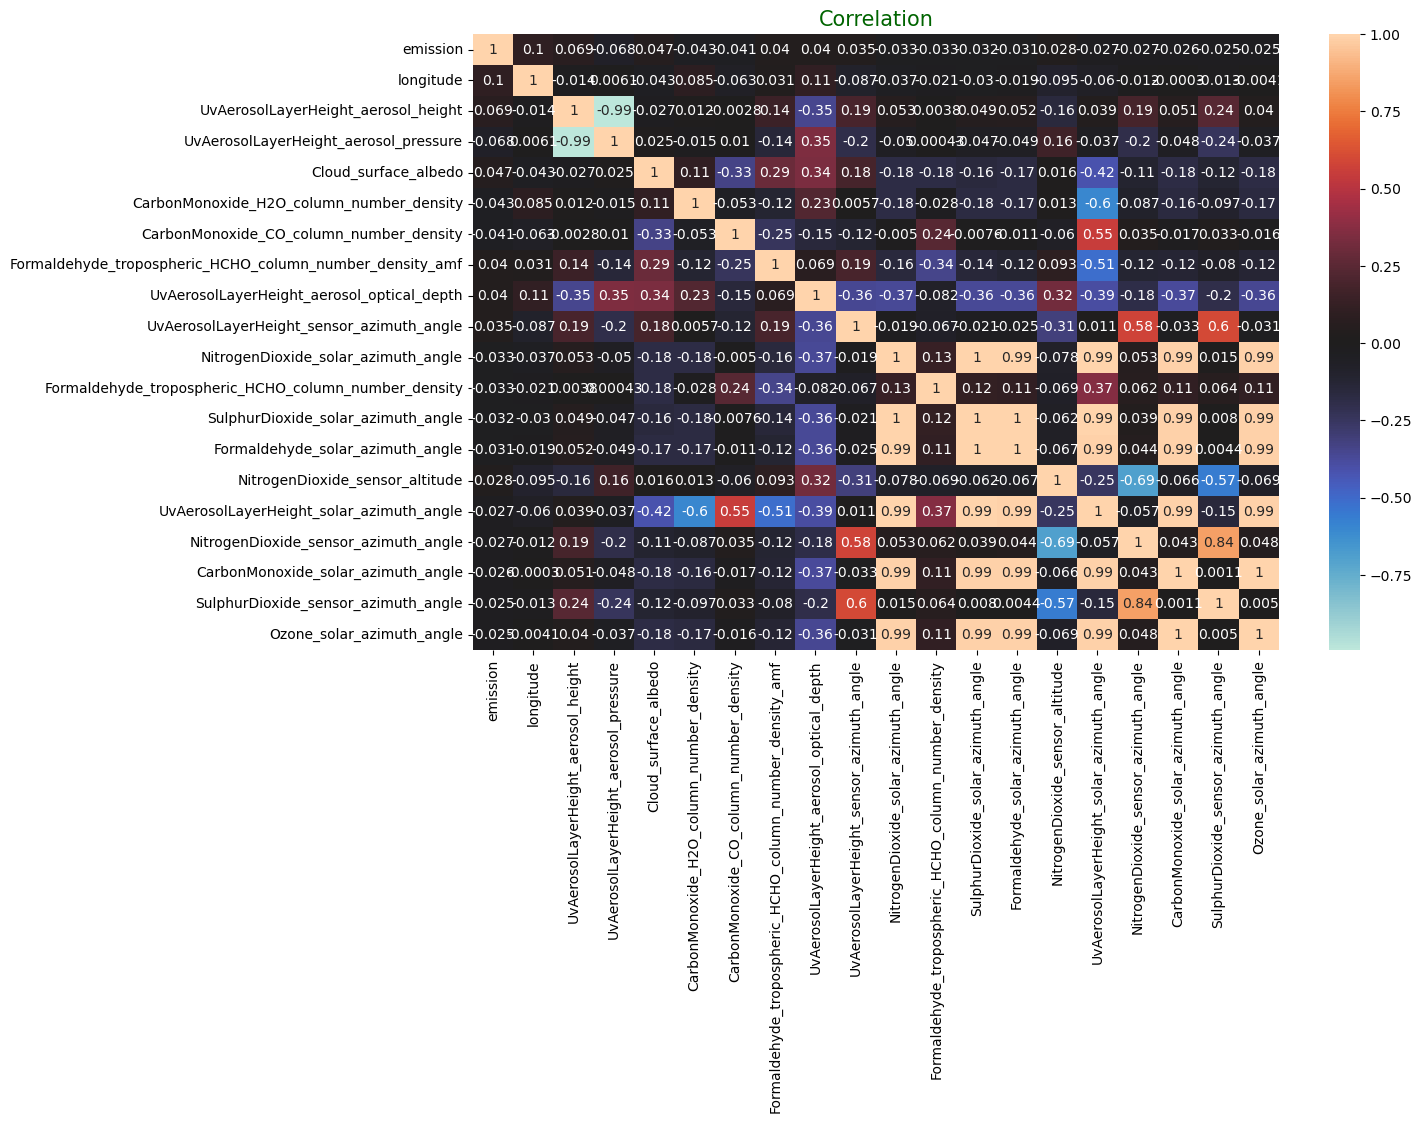

In [6]:
plt.figure(figsize = (13, 8))
sea.heatmap(trainData[top20Cols].corr(), annot = True, center = 0)
plt.title('Correlation', fontsize = 15, color = 'darkgreen')

In [7]:
corr_data[:][trainData.columns[-1]].map(lambda x: abs(x)).sort_values()

SulphurDioxide_SO2_column_number_density_amf    0.000347
Ozone_cloud_fraction                            0.000569
CarbonMonoxide_sensor_zenith_angle              0.000816
Cloud_cloud_fraction                            0.001249
Formaldehyde_cloud_fraction                     0.001254
                                                  ...   
Cloud_surface_albedo                            0.046587
UvAerosolLayerHeight_aerosol_pressure           0.068138
UvAerosolLayerHeight_aerosol_height             0.069008
longitude                                       0.102746
emission                                        1.000000
Name: emission, Length: 75, dtype: float64

In [8]:
years = trainData['year'].unique()
years

array([2019, 2020, 2021])

#### Lineplot for Emission vs Top 20 attribute which has highest correlation with emission

In [1]:
nyears = len(years)
for column in top20Cols[1:]:
    figure, axis = plt.subplots(1,nyears, figsize=(17,7))
    for i,year in enumerate(years):
        yearData = trainData[trainData['year'] == year]
        axis[i].plot(yearData['emission'],yearData[column])
        axis[i].set_title('Year:' + str(year))
        axis[i].set(xlabel='emission', ylabel = column)
    plt.plot()

NameError: name 'years' is not defined

## Pattern of emission over a period of time

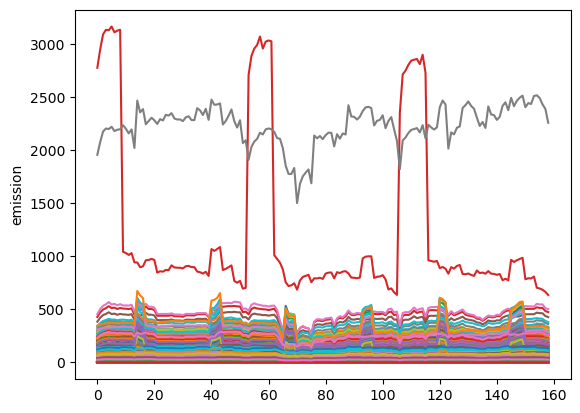

In [10]:
for ll in trainData[['latitude', 'longitude']].drop_duplicates().iterrows():
    latitute, longitude = ll[1].latitude, ll[1].longitude
    time_series = trainData[(trainData.latitude == latitute) & (trainData.longitude == longitude)].emission
    sea.lineplot(x=range(len(time_series)),y=time_series)

### Number of rows having nan value for each attribute

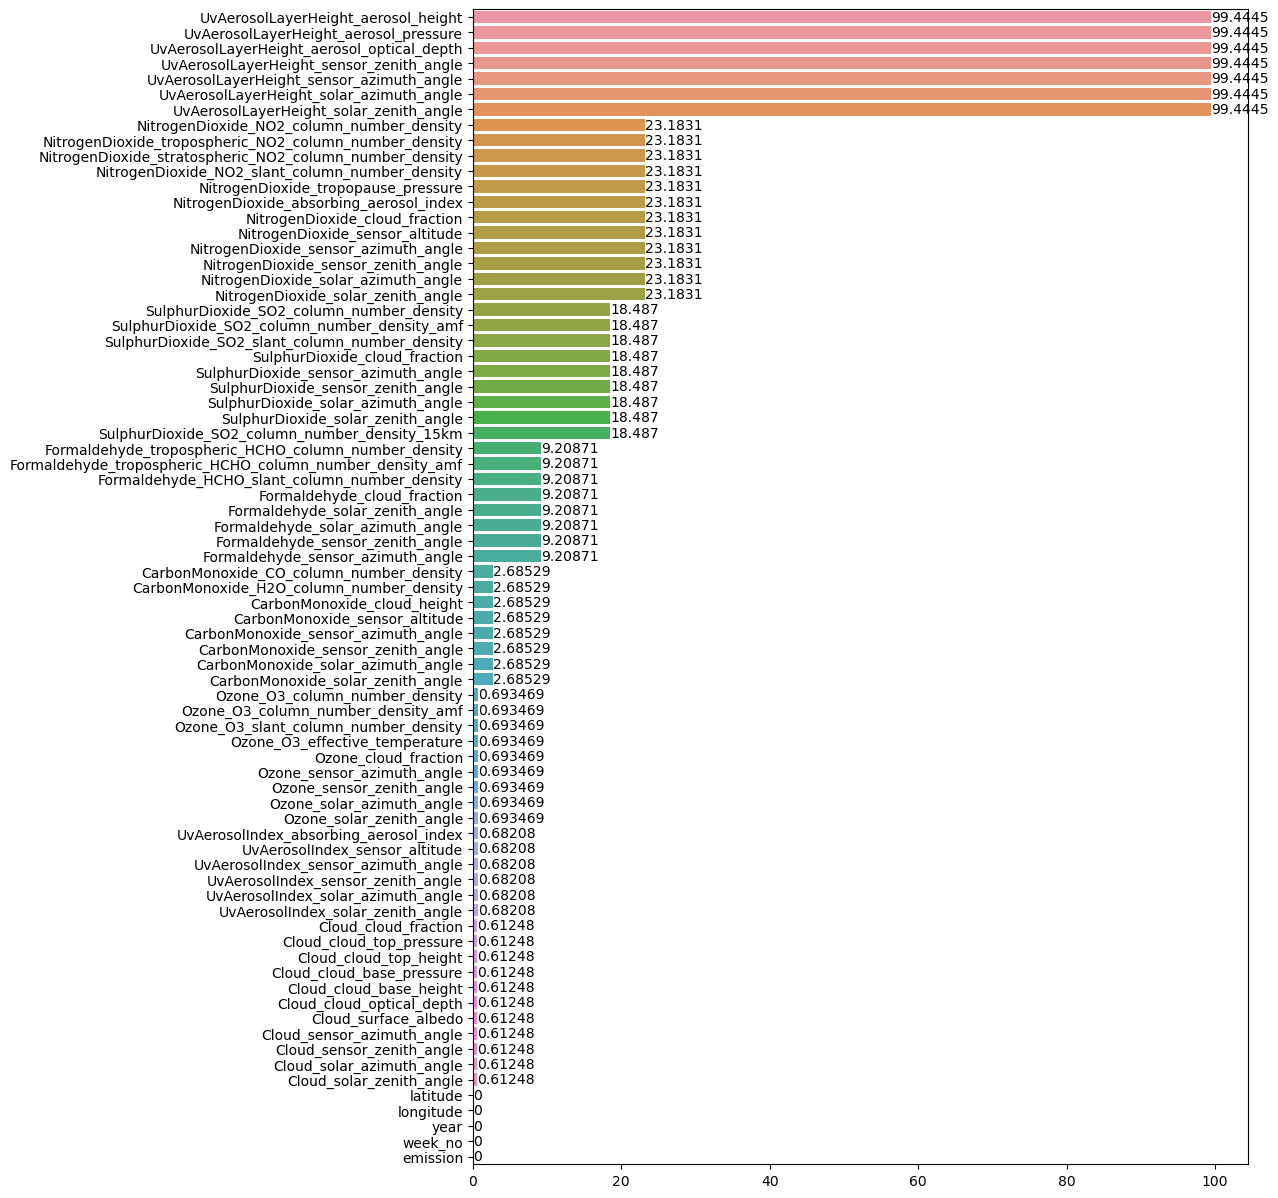

In [11]:
columns = trainData.columns
miss_val = []
for col in columns:
    miss_val.append((col,(trainData[col].isna().sum()/ trainData[col].size) * 100))
miss_val.sort(reverse=True,key=lambda x:x[1])

plt.figure(figsize=(10,15))
ax = sea.barplot(x=[row[1] for row in miss_val], y = [row[0] for row in miss_val],)
_ = ax.bar_label(ax.containers[0], fontsize=10)

In [12]:
trainData.describe()

,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
count,79023.000000,79023.000000,79023.000000,79023.000000,64414.000000,64414.000000,64414.000000,64414.000000,64414.000000,64414.000000,...,78539.000000,78539.000000,78539.000000,78539.000000,78539.000000,78539.000000,78539.000000,78539.000000,78539.000000,79023.000000
mean,-1.891072,29.880155,2020.000000,26.000000,0.000048,0.834848,0.000035,0.158418,-7.925870,37.436189,...,5592.377478,59420.297456,4670.430869,19.139241,0.271460,-10.784832,40.436976,-86.800583,27.925981,81.940552
std,0.694522,0.810375,0.816502,15.297155,0.000272,0.185382,0.000206,0.071364,64.263368,14.149950,...,1428.503002,9051.163609,1359.251583,13.547047,0.049434,30.374462,6.428216,37.837269,4.403835,144.299648
min,-3.299000,28.228000,2019.000000,0.000000,-0.000996,0.241822,-0.000887,0.000000,-179.537059,0.099237,...,1050.661782,24779.033704,1050.496816,1.844529,0.017697,-102.739731,2.998873,-153.464211,10.818288,0.000000
25%,-2.451000,29.262000,2019.000000,13.000000,-0.000096,0.705817,-0.000078,0.110535,-56.782383,28.844520,...,4595.400519,53175.779928,3680.856344,9.974574,0.241453,-30.309170,35.829907,-125.991158,24.686763,9.797995
50%,-1.882000,29.883000,2020.000000,26.000000,0.000024,0.809118,0.000019,0.161855,-12.441726,37.784299,...,5573.854309,59332.532548,4621.755170,15.130688,0.272747,-12.673914,41.119630,-84.644352,28.333630,45.593445
75%,-1.303000,30.471000,2021.000000,39.000000,0.000153,0.942792,0.000121,0.211824,72.059990,47.634875,...,6542.303642,65663.842684,5572.983223,23.785030,0.302892,9.402202,44.446272,-48.132701,31.499883,109.549595
max,-0.510000,31.532000,2021.000000,52.000000,0.004191,1.885239,0.004236,0.299998,122.095200,66.242012,...,12384.239458,89291.615576,11384.239458,250.000000,0.736514,78.223037,65.951248,-22.653170,42.060436,3167.768000


### Filling Missing Values

In [13]:
pData = trainData.copy()
for col in columns:
    if pData[col].isna().sum() > 0:
        pData[col].fillna(pData[col].mean(), inplace=True)

## Simple Linear Regression Model

In [14]:
lr_model = LinearRegression()
trainX, trainY = pData.drop('emission',axis=1), pData['emission']

xtrain, xval, ytrain, yval = train_test_split(trainX,trainY, test_size=0.2, shuffle=True)
lr_model.fit(xtrain, ytrain)

preds = lr_model.predict(xval)
rmse = mean_squared_error(yval, preds, squared=False)
print(f"RMSE = {rmse:.2f}")

RMSE = 141.40


In [15]:
lr_model = LinearRegression()
trainX, trainY = pData.drop(['emission','week_no'],axis=1), pData['emission']

xtrain, xval, ytrain, yval = train_test_split(trainX,trainY, test_size=0.2, shuffle=True)
lr_model.fit(xtrain, ytrain)

preds = lr_model.predict(xval)
rmse = mean_squared_error(yval, preds, squared=False)
print(f"RMSE = {rmse:.2f}")

RMSE = 142.78


In [16]:
lr_model = LinearRegression()
trainX, trainY = pData[top20Cols].drop('emission',axis=1), pData['emission']

xtrain, xval, ytrain, yval = train_test_split(trainX,trainY, test_size=0.2, shuffle=True)
lr_model.fit(xtrain, ytrain)

preds = lr_model.predict(xval)
rmse = mean_squared_error(yval, preds, squared=False)
print(f"RMSE = {rmse:.2f}")

RMSE = 148.53


In [17]:
lr_model = LinearRegression()
trainX, trainY = pData[columns[4:]].drop('emission',axis=1), pData['emission']

xtrain, xval, ytrain, yval = train_test_split(trainX,trainY, test_size=0.2, shuffle=True)
lr_model.fit(xtrain, ytrain)

preds = lr_model.predict(xval)
rmse = mean_squared_error(yval, preds, squared=False)
print(f"RMSE = {rmse:.2f}")

RMSE = 135.52


## Lasso Regression and Ridge Regression

In [18]:
lassoModel = Lasso(alpha=1, max_iter=1500)
trainX, trainY = pData[columns[4:]].drop('emission',axis=1), pData['emission']

xtrain, xval, ytrain, yval = train_test_split(trainX,trainY, test_size=0.2, shuffle=True)
lassoModel.fit(xtrain,ytrain)
preds = lassoModel.predict(xval)
rmse = mean_squared_error(yval, preds, squared=False)
print(f"RMSE = {rmse:.2f}")

RMSE = 140.57


/Users/moxi/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.546e+08, tolerance: 1.331e+05
  model = cd_fast.enet_coordinate_descent(


In [19]:
lassoModel = Ridge(alpha=1)
trainX, trainY = pData[columns[4:]].drop('emission',axis=1), pData['emission']

xtrain, xval, ytrain, yval = train_test_split(trainX,trainY, test_size=0.2, shuffle=True)
lassoModel.fit(xtrain,ytrain)
preds = lassoModel.predict(xval)
rmse = mean_squared_error(yval, preds, squared=False)
print(f"RMSE = {rmse:.2f}")

RMSE = 135.81


In [20]:
lassoModel = Lasso(alpha=1, max_iter=1500)
trainX, trainY = pData[columns[:4]], pData['emission']

xtrain, xval, ytrain, yval = train_test_split(trainX,trainY, test_size=0.2, shuffle=True)
lassoModel.fit(xtrain,ytrain)
preds = lassoModel.predict(xval)
rmse = mean_squared_error(yval, preds, squared=False)
print(f"RMSE = {rmse:.2f}")

RMSE = 142.17


In [31]:
lassoModel = Ridge(alpha=1)
trainX, trainY = pData[columns[:4]], pData['emission']

xtrain, xval, ytrain, yval = train_test_split(trainX,trainY, test_size=0.2, shuffle=True)
lassoModel.fit(xtrain,ytrain)
preds = lassoModel.predict(xval)
rmse = mean_squared_error(yval, preds, squared=False)
print(f"RMSE = {rmse:.2f}")

RMSE = 144.57


In [18]:
lr_model = LinearRegression()
trainX, trainY = pData[columns[:4]], pData['emission']

xtrain, xval, ytrain, yval = train_test_split(trainX,trainY, test_size=0.2, shuffle=True)
lr_model.fit(xtrain, ytrain)

preds = lr_model.predict(xval)
rmse = mean_squared_error(yval, preds, squared=False)
print(f"RMSE = {rmse:.2f}")

RMSE = 148.96


## K Fold Validation (K = 1)

In [19]:
score_list = []
kf = LeaveOneGroupOut()
for fold, (idx_tr, idx_va) in enumerate(kf.split(trainData, groups=trainData.year)):
    X_tr = trainData.iloc[idx_tr][['longitude', 'latitude', 'week_no']]
    y_tr = trainData.iloc[idx_tr]['emission']
    X_va = trainData.iloc[idx_va][['longitude', 'latitude', 'week_no']]
    y_va = trainData.iloc[idx_va]['emission']

    model = LinearRegression()
    model.fit(X_tr, y_tr)
    y_va_pred = model.predict(X_va)
    rmse = mean_squared_error(y_va, y_va_pred, squared=False)
    print(f"Fold {fold} year {trainData.iloc[idx_va].year.iloc[0]}: rmse = {rmse:.2f}")
    score_list.append(rmse)

rmse = sum(score_list) / len(score_list)
print(f"Overall RMSE: {rmse:.2f}")

Fold 0 year 2019: rmse = 148.24
Fold 1 year 2020: rmse = 136.70


Fold 2 year 2021: rmse = 145.72
Overall RMSE: 143.55


In [20]:
score_list = []
kf = LeaveOneGroupOut()
for fold, (idx_tr, idx_va) in enumerate(kf.split(trainData, groups=trainData.year)):
    X_tr = trainData.iloc[idx_tr][['longitude', 'latitude', 'week_no']]
    y_tr = trainData.iloc[idx_tr]['emission']
    X_va = trainData.iloc[idx_va][['longitude', 'latitude', 'week_no']]
    y_va = trainData.iloc[idx_va]['emission']

    model = DecisionTreeRegressor()
    model.fit(X_tr, y_tr)
    y_va_pred = model.predict(X_va)
    rmse = mean_squared_error(y_va, y_va_pred, squared=False)
    print(f"Fold {fold} year {trainData.iloc[idx_va].year.iloc[0]}: rmse = {rmse:.2f}")
    score_list.append(rmse)

rmse = sum(score_list) / len(score_list)
print(f"Overall RMSE: {rmse:.2f}")

Fold 0 year 2019: rmse = 20.29
Fold 1 year 2020: rmse = 27.14
Fold 2 year 2021: rmse = 19.77
Overall RMSE: 22.40


In [21]:
score_list = []
kf = LeaveOneGroupOut()
for fold, (idx_tr, idx_va) in enumerate(kf.split(trainData, groups=trainData.year)):
    X_tr = trainData.iloc[idx_tr][['longitude', 'latitude', 'week_no']]
    y_tr = trainData.iloc[idx_tr]['emission']
    X_va = trainData.iloc[idx_va][['longitude', 'latitude', 'week_no']]
    y_va = trainData.iloc[idx_va]['emission']

    model = RadiusNeighborsRegressor(radius=0)
    model.fit(X_tr, y_tr)
    y_va_pred = model.predict(X_va)
    rmse = mean_squared_error(y_va, y_va_pred, squared=False)
    print(f"Fold {fold} year {trainData.iloc[idx_va].year.iloc[0]}: rmse = {rmse:.2f}")
    score_list.append(rmse)

rmse = sum(score_list) / len(score_list)
print(f"Overall RMSE: {rmse:.2f}")

Fold 0 year 2019: rmse = 20.29
Fold 1 year 2020: rmse = 27.14
Fold 2 year 2021: rmse = 19.77
Overall RMSE: 22.40


In [22]:
score_list = []
kf = LeaveOneGroupOut()
for fold, (idx_tr, idx_va) in enumerate(kf.split(trainData, groups=trainData.year)):
    X_tr = trainData.iloc[idx_tr][['longitude', 'latitude', 'week_no']]
    y_tr = trainData.iloc[idx_tr]['emission']
    X_va = trainData.iloc[idx_va][['longitude', 'latitude', 'week_no']]
    y_va = trainData.iloc[idx_va]['emission']

    model = KNeighborsRegressor(n_neighbors=2)
    model.fit(X_tr, y_tr)
    y_va_pred = model.predict(X_va)
    rmse = mean_squared_error(y_va, y_va_pred, squared=False)
    print(f"Fold {fold} year {trainData.iloc[idx_va].year.iloc[0]}: rmse = {rmse:.2f}")
    score_list.append(rmse)

rmse = sum(score_list) / len(score_list)
print(f"Overall RMSE: {rmse:.2f}")

Fold 0 year 2019: rmse = 20.29
Fold 1 year 2020: rmse = 27.14
Fold 2 year 2021: rmse = 19.77
Overall RMSE: 22.40


## Ensemble Model

In [23]:
trainX, trainY = pData[columns[:4]], pData['emission']

xtrain, xval, ytrain, yval = train_test_split(trainX,trainY, test_size=0.2, shuffle=True)

randomForestRegressor = RandomForestRegressor(n_estimators=1000, random_state=42)
model = BaggingRegressor(estimator=randomForestRegressor, n_estimators=5, random_state=42)

model.fit(xtrain, ytrain)

preds = model.predict(xval)
rmse = mean_squared_error(yval, preds, squared=False)
print(f"RMSE = {rmse:.2f}")

RMSE = 15.38


In [44]:
trainX, trainY = pData[columns[:4]], pData['emission']

xtrain, xval, ytrain, yval = train_test_split(trainX,trainY, test_size=0.2, shuffle=True)
xgBoost = XGBRegressor(n_estimators=1500, max_depth=7, eta=0.1)

model = BaggingRegressor(estimator=xgBoost, n_estimators=100, random_state=42)
model.fit(xtrain, ytrain)

preds = model.predict(xval)
rmse = mean_squared_error(yval, preds, squared=False)
print(f"RMSE = {rmse:.2f}")

RMSE = 10.15


In [49]:
with open('BaggingRegressor','wb') as wp:
    pickle.dump(model, wp)
with open('BaggingRegressor','rb') as fp:
    model = pickle.load(fp)

In [21]:
score_list = []
kf = LeaveOneGroupOut()
for fold, (idx_tr, idx_va) in enumerate(kf.split(trainData, groups=trainData.year)):
    X_tr = trainData.iloc[idx_tr][['longitude', 'latitude', 'week_no']]
    y_tr = trainData.iloc[idx_tr]['emission']
    X_va = trainData.iloc[idx_va][['longitude', 'latitude', 'week_no']]
    y_va = trainData.iloc[idx_va]['emission']

    xgBoost = XGBRegressor(n_estimators=1500, max_depth=7, eta=0.1)
    model = BaggingRegressor(estimator=xgBoost, n_estimators=100, random_state=42)
    
    model.fit(X_tr, y_tr)
    y_va_pred = model.predict(X_va)
    rmse = mean_squared_error(y_va, y_va_pred, squared=False)
    print(f"Fold {fold} year {trainData.iloc[idx_va].year.iloc[0]}: rmse = {rmse:.2f}")
    score_list.append(rmse)

rmse = sum(score_list) / len(score_list)
print(f"Overall RMSE: {rmse:.2f}")

Fold 0 year 2019: rmse = 20.08
Fold 1 year 2020: rmse = 26.75
Fold 2 year 2021: rmse = 19.59
Overall RMSE: 22.14


In [50]:
preds = model.predict(xval)
rmse = mean_squared_error(yval, preds, squared=False)
print(f"RMSE = {rmse:.2f}")

RMSE = 10.15


In [32]:
trainX, trainY = pData[columns[:4]], pData['emission']

xtrain, xval, ytrain, yval = train_test_split(trainX,trainY, test_size=0.2, shuffle=True)
model = MLPRegressor(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(128,256,512,256,128), max_iter=250,)

model.fit(xtrain,ytrain)
preds = model.predict(xval)
rmse = mean_squared_error(yval, preds, squared=False)
print(f"RMSE = {rmse:.2f}")

RMSE = 138.97
